Dispositivo: cuda


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Forma de imagen: torch.Size([3, 64, 64])
Rango de valores: [-0.992, 0.976]
Clase: rana


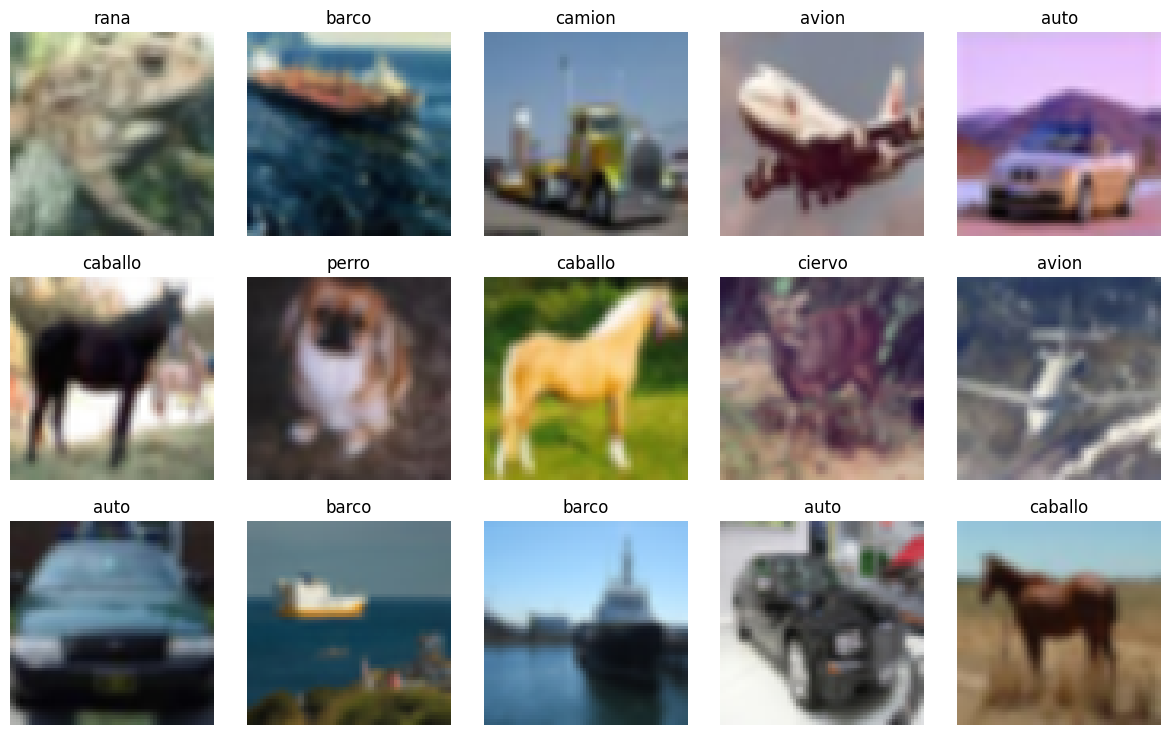

Latent dimension: 100
Image size: 64x64
Number of channels: 3


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
import pandas as pd
import torch.multiprocessing as mp

# Establecer el método de inicio en 'spawn'
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)
# Configuración del dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {device}")

# Paso 1: Configuración del Dataset (CIFAR-10)
# CIFAR-10 es ideal para DenseNet (32x32 RGB)
transform = transforms.Compose([
    transforms.Resize(64),  # Redimensionamos a 64x64 para DenseNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar a [-1, 1]
])

# Descargar y cargar el dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Clases de CIFAR-10
classes = ('avion', 'auto', 'pajaro', 'gato', 'ciervo',
           'perro', 'rana', 'caballo', 'barco', 'camion')

# Dataset personalizado
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = []
        self.labels = []
        for i in range(len(trainset)):
            img, label = trainset[i]
            self.imgs.append(img)
            self.labels.append(label)

        # Remove the .to(device) from here
        self.imgs = torch.stack(self.imgs)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        # Move .to(device) inside __getitem__
        return self.imgs[ix].to(device), self.labels[ix].to(device)

# Crear dataset y dataloader
train_dataset = Dataset(trainset)
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

# Verificar una muestra
img, label = train_dataset[0]
print(f"Forma de imagen: {img.shape}")
print(f"Rango de valores: [{img.min():.3f}, {img.max():.3f}]")
print(f"Clase: {classes[label.item()]}")

# Visualizar algunas imágenes
def show_images(dataset, num_images=15):
    r, c = 3, 5
    plt.figure(figsize=(c*3, r*3))

    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        ix = random.randint(0, len(dataset) - 1)
        img, label = dataset[ix]
        # Convertir de tensor a numpy y desnormalizar
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Desnormalizar
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label.item()])

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

import random
show_images(train_dataset)

# Parámetros importantes
latent_dim = 100  # Dimensión del vector de ruido
img_channels = 3   # CIFAR-10 es RGB
img_size = 64      # Imágenes redimensionadas a 64x64

print(f"Latent dimension: {latent_dim}")
print(f"Image size: {img_size}x{img_size}")
print(f"Number of channels: {img_channels}")

In [ ]:
# Bloque Dense para el Generador
class DenseBlockGenerator(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlockGenerator, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.BatchNorm2d(in_channels + i * growth_rate),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels + i * growth_rate, growth_rate,
                                  kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout2d(0.2)
            ))

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)


In [ ]:
# Capa de Transición para el Generador
class TransitionUpGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUpGenerator, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels,
                              kernel_size=2, stride=2, bias=False)
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
# GENERATOR con Arquitectura DenseNet
class DenseNetGenerator(nn.Module):
    def __init__(self, latent_dim=100, channels=3, growth_rate=32):
        super(DenseNetGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.growth_rate = growth_rate

        # Capa inicial
        self.initial = nn.Sequential(
            nn.Linear(latent_dim, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(inplace=True)
        )

        # Bloques Dense con Transiciones
        self.block1 = DenseBlockGenerator(512, growth_rate, 4)
        self.trans1 = TransitionUpGenerator(512 + 4*growth_rate, 256)

        self.block2 = DenseBlockGenerator(256, growth_rate, 4)
        self.trans2 = TransitionUpGenerator(256 + 4*growth_rate, 128)

        self.block3 = DenseBlockGenerator(128, growth_rate, 4)
        self.trans3 = TransitionUpGenerator(128 + 4*growth_rate, 64)

        # Capa final
        self.final = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = x.view(-1, 512, 4, 4)

        x = self.block1(x)
        x = self.trans1(x)

        x = self.block2(x)
        x = self.trans2(x)

        x = self.block3(x)
        x = self.trans3(x)

        x = self.final(x)
        return x

In [ ]:
# Bloque Dense para el Discriminador
class DenseBlockDiscriminator(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlockDiscriminator, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.BatchNorm2d(current_channels),  # Usar el número actual de canales
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(current_channels, growth_rate,
                         kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout2d(0.2)
            ))
            current_channels += growth_rate  # Incrementar canales por concatenación

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)

In [ ]:
# Capa de Transición para el Discriminador
class TransitionDownDiscriminator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionDownDiscriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, out_channels,
                     kernel_size=2, stride=2, bias=False)
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
# DISCRIMINATOR con Arquitectura DenseNet
class DenseNetDiscriminator(nn.Module):
    def __init__(self, channels=3, growth_rate=32):
        super(DenseNetDiscriminator, self).__init__()
        self.growth_rate = growth_rate

        # Capa inicial
        self.initial = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Bloques Dense con Transiciones
        self.block1 = DenseBlockDiscriminator(64, growth_rate, 4)
        self.trans1 = TransitionDownDiscriminator(64 + 4*growth_rate, 128)

        self.block2 = DenseBlockDiscriminator(128, growth_rate, 4)
        self.trans2 = TransitionDownDiscriminator(128 + 4*growth_rate, 256)

        self.block3 = DenseBlockDiscriminator(256, growth_rate, 4)
        self.trans3 = TransitionDownDiscriminator(256 + 4*growth_rate, 512)

        # Capa final
        self.final = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)

        x = self.block1(x)
        x = self.trans1(x)

        x = self.block2(x)
        x = self.trans2(x)

        x = self.block3(x)
        x = self.trans3(x)

        x = self.final(x)
        return x


In [ ]:
# Crear y probar los modelos
generator = DenseNetGenerator(latent_dim=latent_dim, channels=img_channels).to(device)
discriminator = DenseNetDiscriminator(channels=img_channels).to(device)

# Test del generador
print("Test del Generador:")
test_noise = torch.randn(4, latent_dim).to(device)
test_output = generator(test_noise)
print(f"Input noise shape: {test_noise.shape}")
print(f"Output image shape: {test_output.shape}")

# Test del discriminador
print("\nTest del Discriminador:")
test_images = torch.randn(4, img_channels, img_size, img_size).to(device)
test_d_output = discriminator(test_images)
print(f"Input image shape: {test_images.shape}")
print(f"Output discriminator shape: {test_d_output.shape}")
print(f"Output values: {test_d_output}")

# Contar parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nNúmero de parámetros:")
print(f"Generator: {count_parameters(generator):,}")
print(f"Discriminator: {count_parameters(discriminator):,}")

# Visualizar arquitectura
print("\nArquitectura del Generador:")
print(generator)

print("\nArquitectura del Discriminador:")
print(discriminator)

Test del Generador:
Input noise shape: torch.Size([4, 100])
Output image shape: torch.Size([4, 3, 32, 32])

Test del Discriminador:
Input image shape: torch.Size([4, 3, 64, 64])
Output discriminator shape: torch.Size([4, 1])
Output values: tensor([[0.4190],
        [0.4702],
        [0.4621],
        [0.4163]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Número de parámetros:
Generator: 2,972,099
Discriminator: 1,838,529

Arquitectura del Generador:
DenseNetGenerator(
  (initial): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block1): DenseBlockGenerator(
    (layers): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): ConvTranspose2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

Iniciando entrenamiento de DCGAN con DenseNet...
Device: cuda
Batch size: 32
Latent dimension: 100
Image size: 64x64


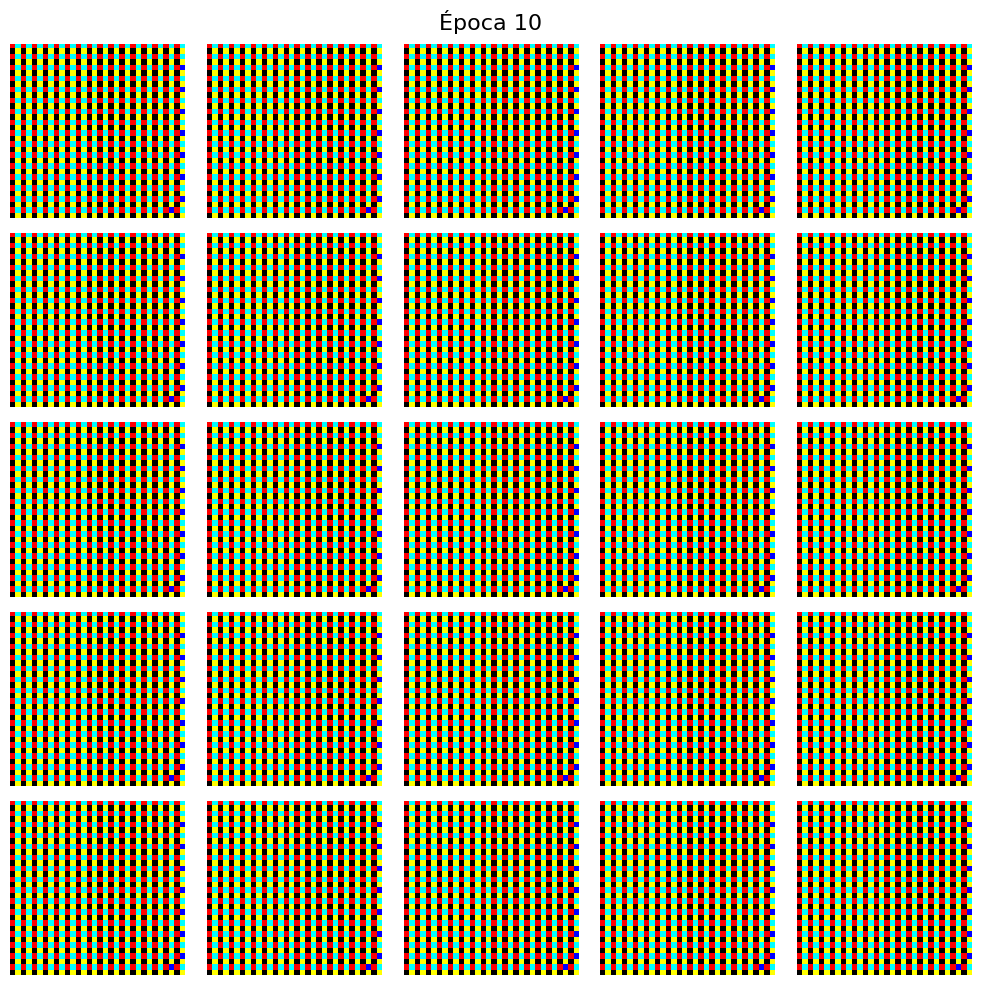

In [ ]:
# Función de entrenamiento mejorada para DCGAN con DenseNet
def fit_densenet_gan(generator, discriminator, dataloader, epochs=100, latent_dim=100):
    generator.to(device)
    discriminator.to(device)

    # Optimizadores
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Función de pérdida
    criterion = nn.BCELoss()

    # Historial de pérdidas
    history = {'g_loss': [], 'd_loss': [], 'real_score': [], 'fake_score': []}

    # Ruido fijo para visualización
    fixed_noise = torch.randn(25, latent_dim, device=device)

    mb = master_bar(range(1, epochs+1))

    for epoch in mb:
        g_losses = []
        d_losses = []
        real_scores = []
        fake_scores = []

        for real_images, _ in progress_bar(dataloader, parent=mb):
            batch_size = real_images.size(0)

            # Etiquetas reales y falsas
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ================================
            # Entrenar el Discriminador
            # ================================
            discriminator.train()
            generator.eval()

            d_optimizer.zero_grad()

            # Forward pass con imágenes reales
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)

            # Forward pass con imágenes falsas
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)

            # Pérdida total del discriminador
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # ================================
            # Entrenar el Generador
            # ================================
            discriminator.eval()
            generator.train()

            g_optimizer.zero_grad()

            # Forward pass con imágenes falsas
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)  # Engañar al discriminador

            g_loss.backward()
            g_optimizer.step()

            # Guardar métricas
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            real_scores.append(real_outputs.mean().item())
            fake_scores.append(fake_outputs.mean().item())

        # Calcular promedios de la época
        avg_g_loss = np.mean(g_losses)
        avg_d_loss = np.mean(d_losses)
        avg_real_score = np.mean(real_scores)
        avg_fake_score = np.mean(fake_scores)

        # Guardar en historial
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        history['real_score'].append(avg_real_score)
        history['fake_score'].append(avg_fake_score)

        # Mostrar progreso
        mb.write(f'Epoch {epoch}/{epochs} | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f} | '
                f'Real Score: {avg_real_score:.4f} | Fake Score: {avg_fake_score:.4f}')

        # Visualizar muestras cada 10 épocas
        if epoch % 10 == 0:
            generator.eval()
            with torch.no_grad():
                fake_images = generator(fixed_noise)
                plot_generated_images(fake_images, epoch)

    return history

# Función para visualizar imágenes generadas
def plot_generated_images(images, epoch, nrows=5, ncols=5):
    images = images.cpu()
    images = (images + 1) / 2  # Desnormalizar de [-1, 1] a [0, 1]
    images = images.clamp(0, 1)

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f'Época {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Función para graficar el historial de entrenamiento
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Pérdidas
    ax1.plot(history['g_loss'], label='Generator Loss')
    ax1.plot(history['d_loss'], label='Discriminator Loss')
    ax1.set_title('Pérdidas durante el entrenamiento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Scores
    ax2.plot(history['real_score'], label='Real Score', alpha=0.7)
    ax2.plot(history['fake_score'], label='Fake Score', alpha=0.7)
    ax2.set_title('Scores del Discriminador')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True)

    # Ratio de scores
    ax3.plot(np.array(history['real_score']) / np.array(history['fake_score']),
             label='Real/Fake Ratio', color='purple')
    ax3.set_title('Ratio Real/Fake')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Ratio')
    ax3.axhline(y=1, color='r', linestyle='--', alpha=0.5)
    ax3.legend()
    ax3.grid(True)

    # Pérdidas en escala logarítmica
    ax4.semilogy(history['g_loss'], label='Generator Loss')
    ax4.semilogy(history['d_loss'], label='Discriminator Loss')
    ax4.set_title('Pérdidas (escala log)')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Pérdida (log)')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

# Función para generar y guardar imágenes
def generate_and_save_images(generator, num_images=64, latent_dim=100):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, device=device)
        generated_images = generator(noise)
        generated_images = (generated_images + 1) / 2  # Desnormalizar
        generated_images = generated_images.clamp(0, 1)

    # Crear grid de imágenes
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=8, padding=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title('Imágenes generadas')
    plt.show()

    return generated_images

# Iniciar el entrenamiento
print("Iniciando entrenamiento de DCGAN con DenseNet...")
print(f"Device: {device}")
print(f"Batch size: {dataloader.batch_size}")
print(f"Latent dimension: {latent_dim}")
print(f"Image size: {img_size}x{img_size}")

# Entrenar el modelo
history = fit_densenet_gan(
    generator,
    discriminator,
    dataloader,
    epochs=30,
    latent_dim=latent_dim
)

# Graficar historial de entrenamiento
plot_training_history(history)

# Generar imágenes finales
final_images = generate_and_save_images(generator)

print("Entrenamiento completado!")

# **INTENTO 2 CON CLAUDE**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress import master_bar, progress_bar

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


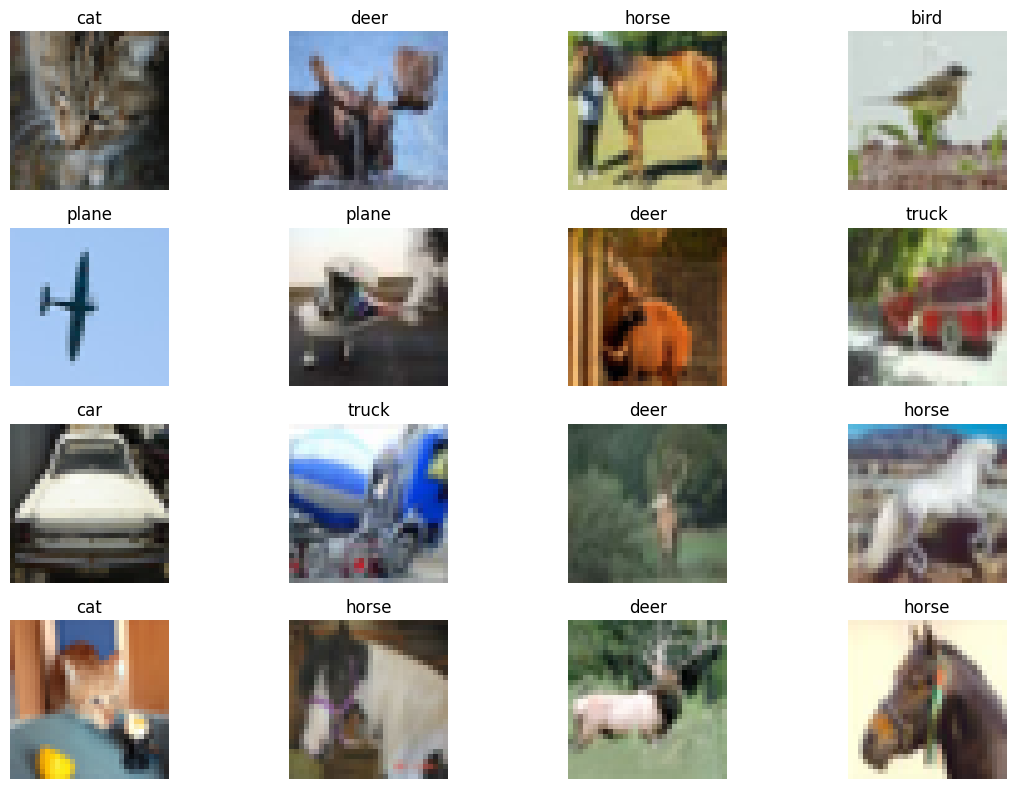

In [ ]:
# Cargar CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar a [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualizar algunas imágenes del dataset
def show_images():
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Desnormalizar para visualización
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images()


In [ ]:
# Bloque denso para DenseNet
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm2d(in_channels + i * growth_rate),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels + i * growth_rate, 4 * growth_rate, 1, bias=False),
                nn.BatchNorm2d(4 * growth_rate),
                nn.ReLU(inplace=True),
                nn.Conv2d(4 * growth_rate, growth_rate, 3, padding=1, bias=False)
            )
            self.layers.append(layer)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)


In [ ]:
# Bloque de transición para DenseNet
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.transition(x)


In [ ]:
# Generador basado en DenseNet con ConvTranspose2d
class DenseNetGenerator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(DenseNetGenerator, self).__init__()
        self.nz = nz

        # Proyección inicial
        self.initial = nn.Sequential(
            nn.Linear(nz, 4 * 4 * 512),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.ReLU(True)
        )

        # Primera upsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        # Bloque denso 1 (reducido)
        self.dense1 = DenseBlock(256, 32, 2)  # Reducir número de capas
        # Después del dense block: 256 + 2*32 = 320 canales
        self.trans1 = nn.Sequential(
            nn.BatchNorm2d(320),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(320, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Bloque denso 2 (reducido)
        self.dense2 = DenseBlock(128, 16, 2)  # Reducir número de capas
        # Después del dense block: 128 + 2*16 = 160 canales
        self.trans2 = nn.Sequential(
            nn.BatchNorm2d(160),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(160, 64, 4, 2, 1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        # Capa final
        self.final = nn.Sequential(
            nn.Conv2d(64, nc, 3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = x.view(-1, 512, 4, 4)

        x = self.up1(x)      # 4x4 -> 8x8
        x = self.dense1(x)
        x = self.trans1(x)   # 8x8 -> 16x16

        x = self.dense2(x)
        x = self.trans2(x)   # 16x16 -> 32x32

        x = self.final(x)
        return x


In [ ]:
# Discriminador basado en DenseNet
class DenseNetDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(DenseNetDiscriminator, self).__init__()

        # Capa inicial
        self.initial = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Bloque denso 1
        self.dense1 = DenseBlock(64, 16, 2)  # Reducir número de capas
        # 64 + 2*16 = 96 canales
        self.trans1 = TransitionBlock(96, 128)  # 16x16 -> 8x8

        # Bloque denso 2
        self.dense2 = DenseBlock(128, 32, 2)  # Reducir número de capas
        # 128 + 2*32 = 192 canales
        self.trans2 = TransitionBlock(192, 256)  # 8x8 -> 4x4

        # Capas finales con dimensiones correctas
        self.conv1 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 1, 0, bias=False),  # 4x4 -> 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(512, 1, 1, 1, 0, bias=False),  # 1x1 -> 1x1 (usar kernel 1x1)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)  # 32x32 -> 16x16
        x = self.dense1(x)
        x = self.trans1(x)   # 16x16 -> 8x8
        x = self.dense2(x)
        x = self.trans2(x)   # 8x8 -> 4x4
        x = self.conv1(x)    # 4x4 -> 1x1
        x = self.conv2(x)    # 1x1 -> 1x1
        return x.view(-1, 1).squeeze(1)


In [ ]:
# Función de entrenamiento mejorada
def train_dcgan(generator, discriminator, dataloader, epochs=50, lr=0.0002, beta1=0.5):
    generator.to(device)
    discriminator.to(device)

    # Optimizadores
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    criterion = nn.BCELoss()

    # Listas para almacenar pérdidas
    g_losses = []
    d_losses = []

    # Labels para real/fake
    real_label = 1.0
    fake_label = 0.0

    mb = master_bar(range(epochs))

    for epoch in mb:
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        num_batches = 0

        for i, (real_images, _) in enumerate(progress_bar(dataloader, parent=mb)):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            ############################
            # Entrenar Discriminador
            ############################
            discriminator.zero_grad()

            # Entrenar con imágenes reales
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_images)
            d_loss_real = criterion(output, label)
            d_loss_real.backward()

            # Entrenar con imágenes falsas
            noise = torch.randn(batch_size, generator.nz, device=device)
            fake_images = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake_images.detach())
            d_loss_fake = criterion(output, label)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()

            ############################
            # Entrenar Generador
            ############################
            generator.zero_grad()
            label.fill_(real_label)  # Las imágenes falsas son etiquetadas como reales para el generador
            output = discriminator(fake_images)
            g_loss = criterion(output, label)
            g_loss.backward()
            g_optimizer.step()

            # Estadísticas
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            num_batches += 1

            mb.child.comment = f'G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}'

        # Promediar pérdidas de la época
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches

        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        mb.write(f'Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}')

    return {'g_loss': g_losses, 'd_loss': d_losses}


In [ ]:
# Inicializar modelos
generator = DenseNetGenerator()
discriminator = DenseNetDiscriminator()

print("Arquitectura del Generador:")
print(generator)
print("\nArquitectura del Discriminador:")
print(discriminator)

Arquitectura del Generador:
DenseNetGenerator(
  (initial): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (dense1): DenseBlock(
    (layers): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )

In [ ]:
# Inicialización de pesos
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

DenseNetDiscriminator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dense1): DenseBlock(
    (layers): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Sequential(
        (0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
# Entrenar el modelo
print("Iniciando entrenamiento...")
history = train_dcgan(generator, discriminator, dataloader, epochs=30)

Iniciando entrenamiento...


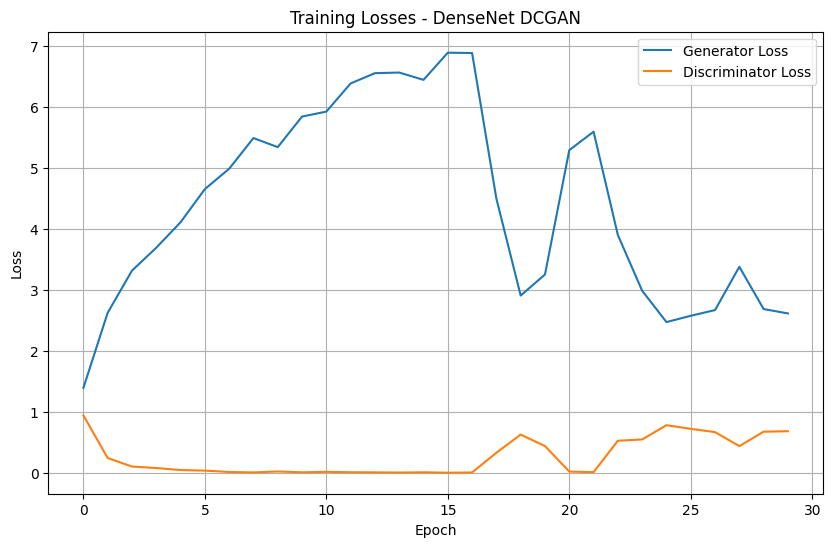

In [ ]:
# Visualizar pérdidas
df = pd.DataFrame(history)
plt.figure(figsize=(10, 6))
plt.plot(df['g_loss'], label='Generator Loss')
plt.plot(df['d_loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses - DenseNet DCGAN')
plt.legend()
plt.grid(True)
plt.show()

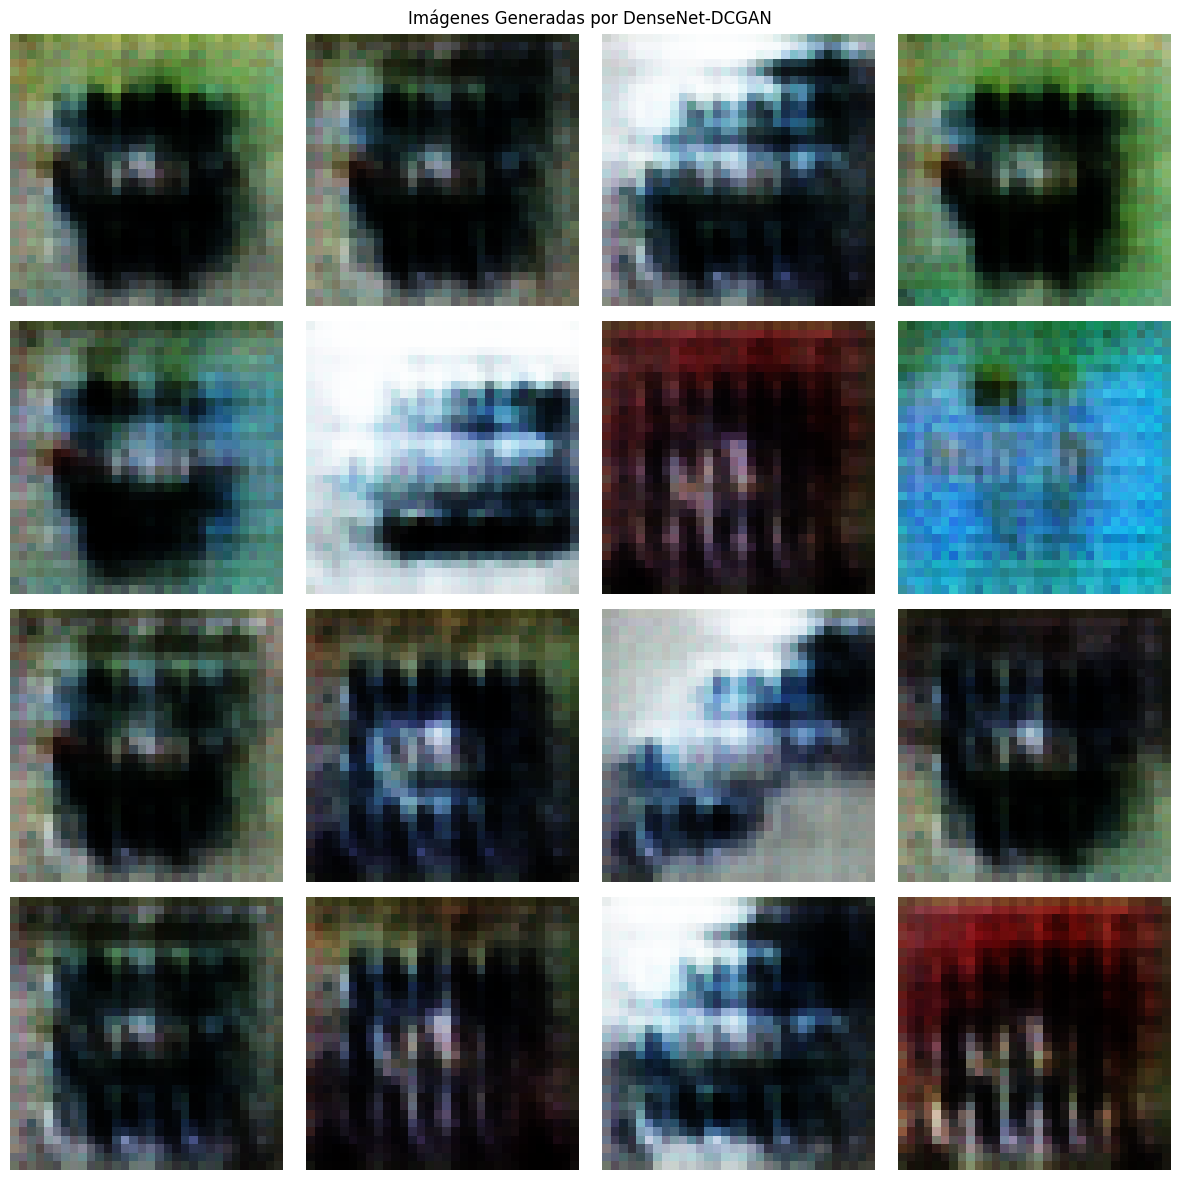

Entrenamiento completado!
Pérdida final del Generador: 2.6184
Pérdida final del Discriminador: 0.6861


In [ ]:
# Generar y visualizar imágenes
def generate_images(generator, num_images=16):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, generator.nz, device=device)
        fake_images = generator(noise)

        plt.figure(figsize=(12, 12))
        for i in range(num_images):
            plt.subplot(4, 4, i+1)
            img = fake_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5  # Desnormalizar
            img = torch.clamp(img, 0, 1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle('Imágenes Generadas por DenseNet-DCGAN')
        plt.tight_layout()
        plt.show()

generate_images(generator)

print("Entrenamiento completado!")
print(f"Pérdida final del Generador: {history['g_loss'][-1]:.4f}")
print(f"Pérdida final del Discriminador: {history['d_loss'][-1]:.4f}")